In [1]:
import os
import h5py
import fitsio
import numpy as np
from tqdm import tqdm
import astropy.table as aTable

In [2]:
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [12]:
# -- plotting -- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# read in target catalog

In [3]:
ff = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/fuji/LSScats/EDAbeta/BGS_ANY_full.dat.fits')

In [4]:
# select only BGS targets
is_bgs_bright = (
    (ff['COADD_FIBERSTATUS'] == 0) & 
    ((ff['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0) & 
    (ff['SPECTYPE'] == 'GALAXY') & 
    (ff['Z_HP'] > 0.) & (ff['Z_HP'] < 0.6) & 
    (ff['ZWARN'] == 0) & 
    (ff['DELTACHI2'] > 40.) & 
    (ff['ZERR'] < 0.0005 * (1 + ff['Z_HP'])))

is_bgs_faint = (
    (ff['COADD_FIBERSTATUS'] == 0) & 
    ((ff['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0) & 
    (ff['SPECTYPE'] == 'GALAXY') & 
    (ff['Z_HP'] > 0.) & (ff['Z_HP'] < 0.6) & 
    (ff['ZWARN'] == 0) & 
    (ff['DELTACHI2'] > 40.) & 
    (ff['ZERR'] < 0.0005 * (1 + ff['Z_HP'])))

print('%i BGS BRIGHT z-success' % np.sum(is_bgs_bright))
print('%i BGS FAINT z-success' % np.sum(is_bgs_faint))

143074 BGS BRIGHT z-success
96771 BGS FAINT z-success


# read in VAGC

In [5]:
fvagc = '/global/cfs/cdirs/desi/users/chahah/provabgs/svda/BGS_ANY_full.provabgs.hdf5'
vagc = aTable.Table.read(fvagc)

In [6]:
vagc[:5]

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,"provabgs_mcmc [100,13]",provabgs_theta_bf [13],provabgs_z_max,provabgs_logMstar_bf,provabgs_logMstar [100],SCHLEGEL_COLOR,provabgs_w_zfail,provabgs_w_fibassign,is_bgs_bright,is_bgs_faint
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool
39633390185481181,191.17913199949842,60.25733587654764,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390164510024,188.6998080571996,60.21175772175424,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,3.225,False,False
39633390185480955,191.14955067198017,60.34047183206205,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,0.1059712957858181,1.0369954283580962,3.0714285714285716,True,False
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,-0.3616078306686752,1.0018031916676053,1.0,True,False


In [7]:
has_va = (vagc['provabgs_z_max'] != -999.)

In [8]:
print('%i of %i BGS BRIGHT has VAGC' % (np.sum(is_bgs_bright & has_va), np.sum(is_bgs_bright)))
print('%i of %i BGS FAINT has VAGC' % (np.sum(is_bgs_faint & has_va), np.sum(is_bgs_faint)))

143017 of 143074 BGS BRIGHT has VAGC
95499 of 96771 BGS FAINT has VAGC


In [9]:
print('%i of %i BGS BRIGHT does not have VAGC' % (np.sum(is_bgs_bright & ~has_va), np.sum(is_bgs_bright)))
print('%i of %i BGS FAINT does not have VAGC' % (np.sum(is_bgs_faint & ~has_va), np.sum(is_bgs_faint)))

57 of 143074 BGS BRIGHT does not have VAGC
1272 of 96771 BGS FAINT does not have VAGC


# examine $M_*-z$ relation
to see if there's anything unusual to check

(6.0, 13.0)

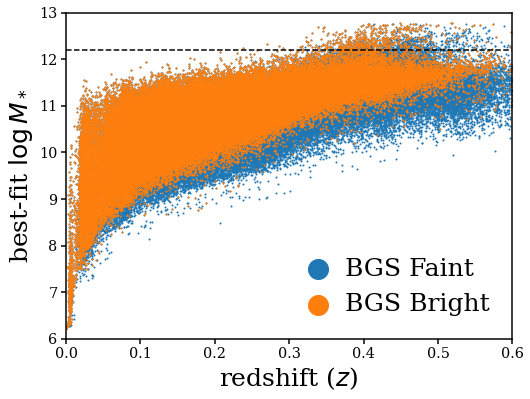

In [16]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['Z_HP'].data, vagc['provabgs_logMstar_bf'].data, c='C0', s=1, label='BGS Faint')
sub.scatter(vagc['Z_HP'].data[vagc['is_bgs_bright']], vagc['provabgs_logMstar_bf'].data[vagc['is_bgs_bright']], 
            c='C1', s=1, label='BGS Bright')
sub.plot([0., 0.6], [12.2, 12.2], c='k', ls='--')
sub.legend(loc='lower right', fontsize=25, markerscale=20, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=25)
sub.set_ylim(6., 13.)

In [17]:
logMstar_med = np.median(vagc['provabgs_logMstar'], axis=1)

(6.0, 13.0)

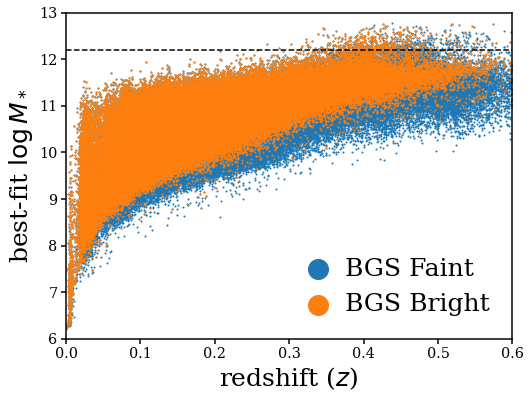

In [18]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['Z_HP'].data, logMstar_med, c='C0', s=1, label='BGS Faint')
sub.scatter(vagc['Z_HP'].data[vagc['is_bgs_bright']], logMstar_med[vagc['is_bgs_bright']], 
            c='C1', s=1, label='BGS Bright')
sub.plot([0., 0.6], [12.2, 12.2], c='k', ls='--')
sub.legend(loc='lower right', fontsize=25, markerscale=20, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r"median $\log M_*$", fontsize=25)
sub.set_ylim(6., 13.)

In [20]:
print('%i galaxies have unusually high M*' % np.sum(vagc['provabgs_logMstar_bf'] > 12.2 ))

1137 galaxies have unusually high M*


Text(0, 0.5, '$g-r$ color')

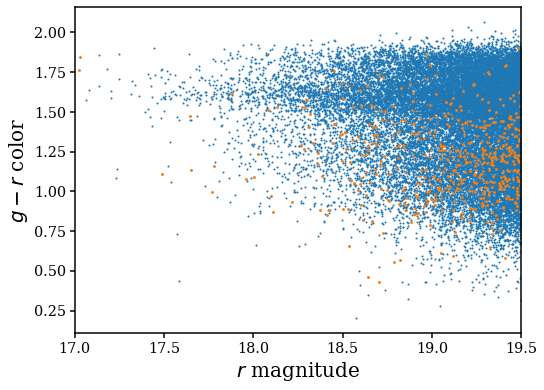

In [33]:
zlim = (vagc['Z_HP'] > 0.3) & (vagc['Z_HP'] < 0.5)

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(vagc['MAG_R'][zlim & vagc['is_bgs_bright']], 
            (vagc['MAG_G'] - vagc['MAG_R'])[zlim & vagc['is_bgs_bright']], 
            c='C0', s=1)
sub.scatter(vagc['MAG_R'][zlim & vagc['is_bgs_bright'] & (vagc['provabgs_logMstar_bf'] > 12.2)], 
            (vagc['MAG_G'] - vagc['MAG_R'])[zlim & vagc['is_bgs_bright'] & (vagc['provabgs_logMstar_bf'] > 12.2)], 
            c='C1', s=3)
sub.set_xlabel('$r$ magnitude', fontsize=20)
sub.set_xlim(17., 19.5)
sub.set_ylabel('$g-r$ color', fontsize=20)

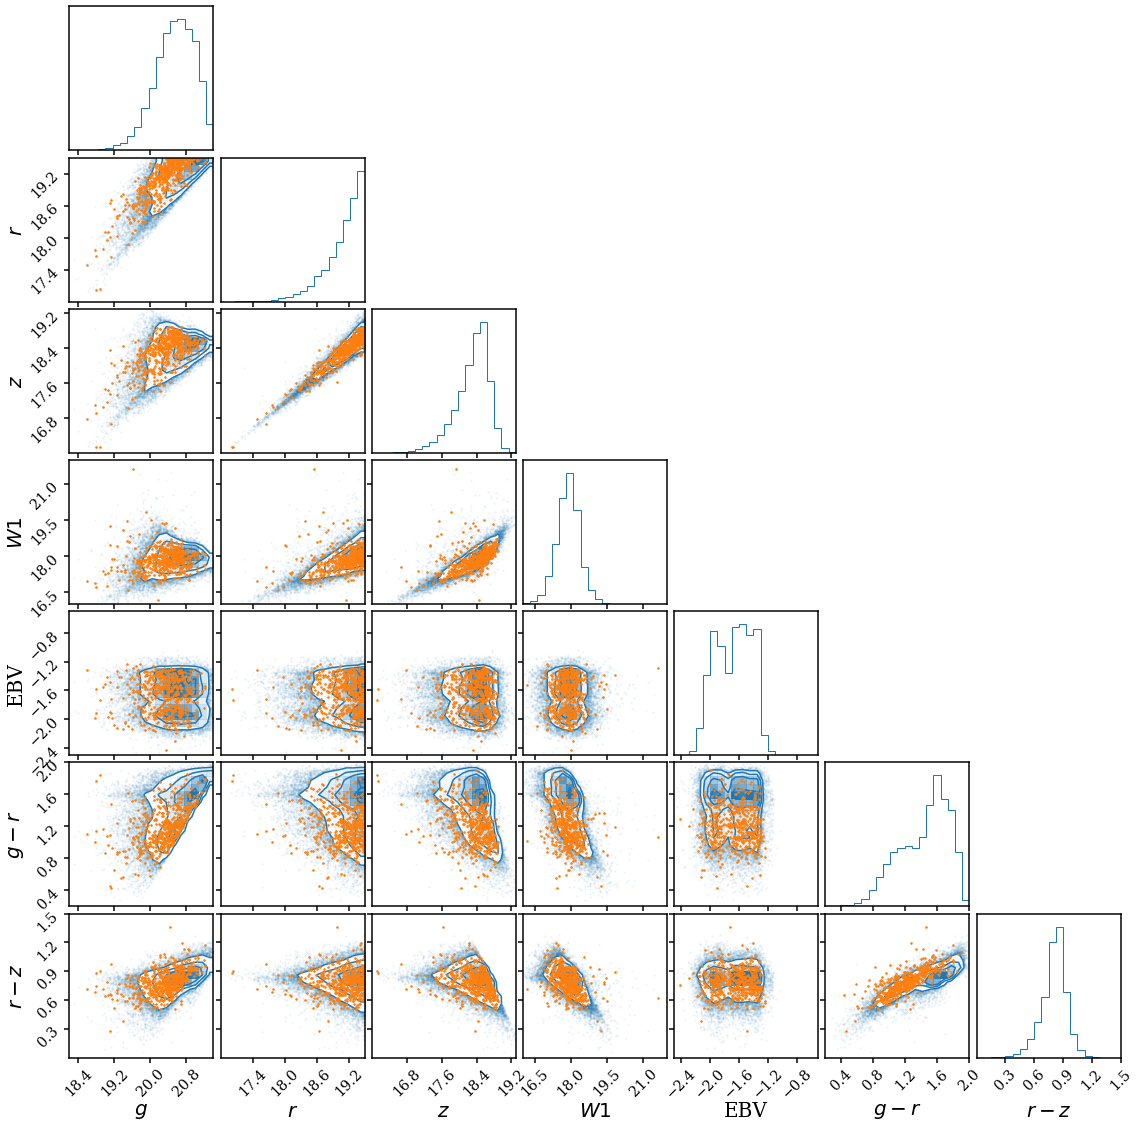

In [80]:
dset = np.array([vagc['MAG_G'], vagc['MAG_R'], vagc['MAG_Z'], vagc['MAG_W1'], np.log10(ff['EBV']),  
                 vagc['MAG_G'] - vagc['MAG_R'], vagc['MAG_R'] - vagc['MAG_Z']])

fig = DFM.corner(dset.T[zlim & vagc['is_bgs_bright']], color='C0',
                range=[(18.2, 21.4), (16.8, 19.5), (16., 19.3), (16, 22), (-2.5, -0.5), (0.2, 2.0), (0., 1.5)], 
                labels=['$g$', '$r$', '$z$', '$W1$', 'EBV', '$g-r$', '$r-z$'], label_kwargs={'fontsize': 20})
DFM.overplot_points(fig, dset.T[zlim & vagc['is_bgs_bright'] & (vagc['provabgs_logMstar_bf'] > 12.2)], 
                    color='C1', markersize=3)

  0%|          | 0/5 [00:00<?, ?it/s]

[20.62040886 19.30918366 18.48899105]


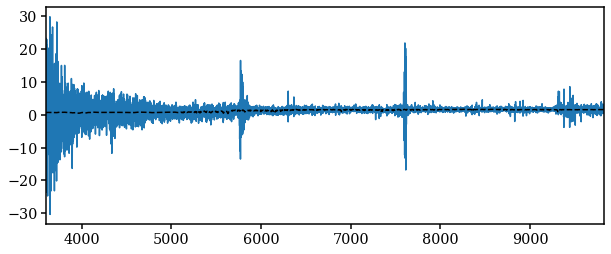

[20.56412348 19.32372138 18.51795543]


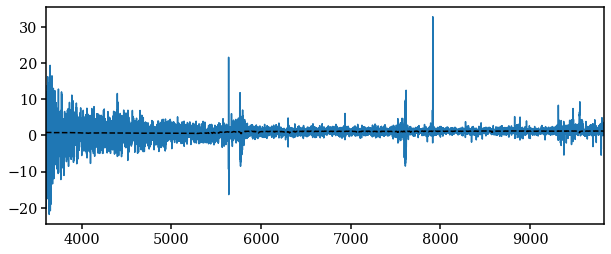

 40%|████      | 2/5 [00:00<00:00, 11.39it/s]

[20.910425   19.23348441 18.32165961]


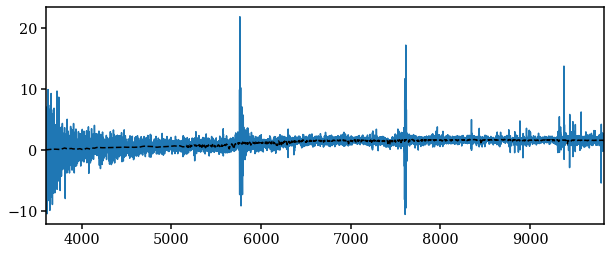

[20.21835367 19.0712813  18.34727861]


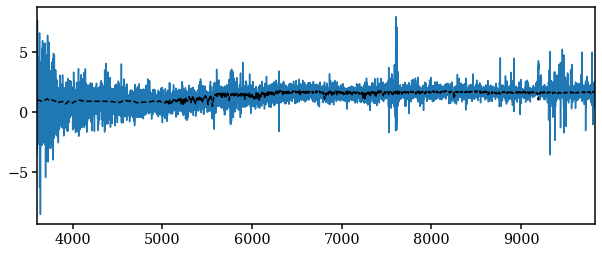

 80%|████████  | 4/5 [00:00<00:00, 11.65it/s]

[20.29906731 18.84916541 17.95204975]


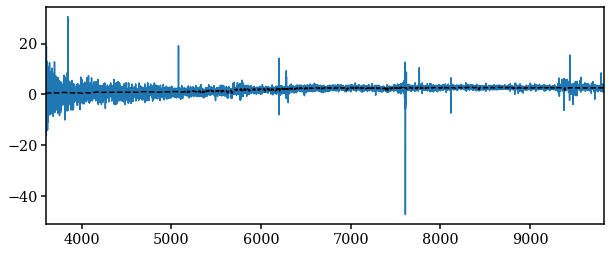

100%|██████████| 5/5 [00:00<00:00, 11.99it/s]


In [62]:
dat_dir = '/global/cfs/cdirs/desi/users/chahah/provabgs/svda/'

for i in tqdm(np.arange(len(vagc))[vagc['is_bgs_bright'] & (vagc['provabgs_logMstar_bf'] > 12.2)][:5]): 
    hpix = vagc['HPIX_64'][i]
    tid = vagc['TARGETID'][i]
    
    fhpix = os.path.join(dat_dir, f'provabgs-sv3-bright-{hpix}.BGS_BRIGHT.hdf5')    
    #try: 
    with h5py.File(fhpix, 'r') as fhpix: 
        tids = fhpix['targetid'][...] # target id
        
        is_targ = (tids == tid)
        wave = fhpix['wavelength_obs'][is_targ,:][0]
        spec_obs = fhpix['flux_spec_obs'][is_targ,:][0]
        spec_mod = fhpix['flux_spec_model'][is_targ,:][0]
        
        print(22.5 - 2.5 * np.log10(fhpix['flux_photo_obs'][is_targ,:][0]))
        #print(fhpix['flux_photo_model'][is_targ,:][0])
    fig = plt.figure(figsize=(10,4))
    sub = fig.add_subplot(111)
    sub.plot(wave, spec_obs, c='C0')
    sub.plot(wave, spec_mod, c='k', ls='--')
    sub.set_xlim(wave.min(), wave.max())
    plt.show()